In [187]:
import gzip
import numpy as np
from collections import namedtuple, defaultdict
import matplotlib.pyplot as plt
from itertools import groupby, islice
import json
from pysam import TabixFile
from statsmodels.stats.proportion import proportion_confint
import scipy.stats as stats

In [128]:
Crossover = namedtuple('Crossover', ['family', 'chrom', 'start_pos', 'end_pos', 'child', 'is_mat', 'is_pat'])


In [129]:
with open('../data/shapeit/children.json', 'r') as f:
    children = json.load(f)
print(len(children))

4330


In [130]:
with open('../data/shapeit/crossovers.json', 'r') as f:
    crossovers = json.load(f)
print(len(crossovers))

210500


In [131]:
num_mat_crossovers = np.load('../data/shapeit/num_mat_crossovers.npy')
num_pat_crossovers = np.load('../data/shapeit/num_pat_crossovers.npy')

In [262]:
print(crossovers[0])
print(len([x for x in crossovers if x[5]]))
print(len([x for x in crossovers if not x[5]]))

['13750', '10', 74561, 74746, 'SS0012979', True, False]
106624
103876


In [242]:
child_to_mat_crossovers = defaultdict(int)
child_to_pat_crossovers = defaultdict(int)
child_to_crossovers = defaultdict(int)
for co in crossovers:
    if co[5]:
        child_to_mat_crossovers[co[4]] += 1
    else:
        child_to_pat_crossovers[co[4]] += 1
    child_to_crossovers[co[4]] += 1

In [134]:
platinum_mat_crossovers = np.zeros((11,))
platinum_pat_crossovers = np.zeros((11,))

with open('../data/GenotypeFiles/haplotype_transmission_hg19.txt', 'r') as f:
    prev_pieces = None
    for line in f:
        if line.startswith('chr10'):
            pieces = line.strip().split()
            
            if prev_pieces is None:
                pass
            else:
                for i in range(11):
                    if prev_pieces[5+i][0] != pieces[5+i][0]:
                        platinum_pat_crossovers[i] += 1
                    if prev_pieces[5+i][1] != pieces[5+i][1]:
                        platinum_mat_crossovers[i] += 1
                    
            prev_pieces = pieces
print(platinum_mat_crossovers)
print(platinum_pat_crossovers)
print(np.median(platinum_mat_crossovers), np.median(platinum_pat_crossovers))

[1. 3. 2. 3. 3. 2. 3. 2. 1. 3. 1.]
[1. 0. 2. 1. 1. 0. 0. 0. 1. 2. 2.]
2.0 1.0


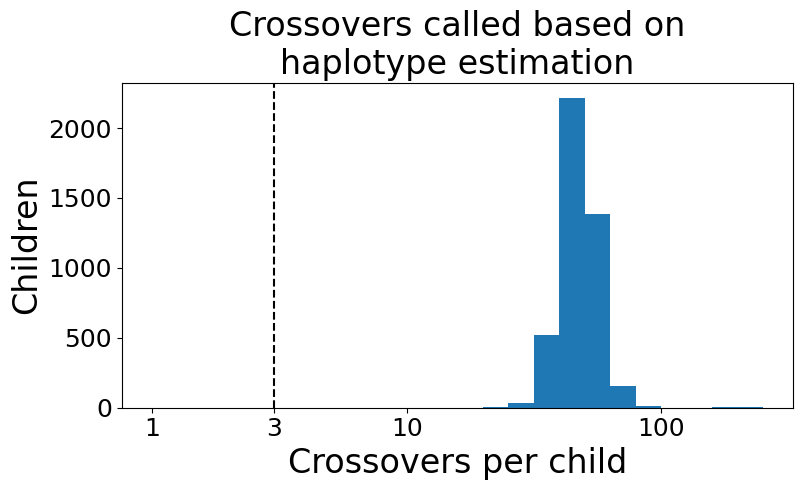

In [243]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(np.log10(list(child_to_crossovers.values())), bins=np.arange(0, 2.5, 0.1))
plt.axvline(np.log10(np.median(platinum_mat_crossovers+platinum_pat_crossovers)), color='black', linestyle='--')
plt.xticks([0, np.log10(3), 1, 2], ['1', '3', '10', '100'], fontsize=18)
plt.yticks(fontsize=18)
plt.title('Crossovers called based on\nhaplotype estimation', fontsize=24)
plt.xlabel('Crossovers per child', fontsize=24)
plt.ylabel('Children', fontsize=24)

plt.tight_layout()
plt.show()



/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_55933/1242235406.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.violinplot(np.log10(num_mat_crossovers+num_pat_crossovers))


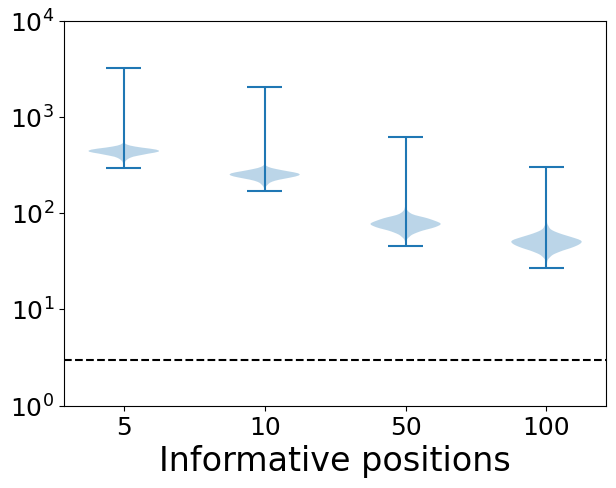

In [248]:
plt.figure(figsize=(7, 5))

plt.violinplot(np.log10(num_mat_crossovers+num_pat_crossovers))
plt.axhline(np.log10(3), color='black', linestyle='--')
plt.yticks(np.arange(5), ['$10^%d$' % x for x in np.arange(5)], fontsize=18)
plt.xticks(np.arange(1, 5), ['5', '10', '50', '100'], fontsize=18)
plt.xlabel('Informative positions', fontsize=24)

plt.savefig('../plots/Supplemental_Fig_S29.png', bbox_inches="tight")

# Compare to my crossovers

In [249]:
print(crossovers[0])

['13750', '10', 74561, 74746, 'SS0012979', True, False]


In [250]:
data_dir = '../../DATA/ssc.hg38'
with open('%s/phase/crossovers.json' % data_dir, 'r') as f:
    my_crossovers = [Crossover(x['family'], x['chrom'], x['start_pos'], x['end_pos'], \
                               x['child'], x['is_mat'], x['is_pat']) for x in json.load(f) if x['chrom']=='10']

families_included = set()
siblings = set()
for x in my_crossovers:
    if x.family not in families_included and x.child[0] not in siblings and x.child[1] not in siblings:
        families_included.add(x.family)
        siblings.add(x.child[0])
        siblings.add(x.child[1])
        
siblings = sorted(set([x.child[0] for x in my_crossovers]) | set([x.child[1] for x in my_crossovers]))
print('siblings', len(siblings))

my_crossovers = [x for x in my_crossovers if x.family in families_included]
print('crossovers', len(my_crossovers), np.median([x.end_pos - x.start_pos for x in my_crossovers]))

shapeit_crossovers = [Crossover(*x) for x in crossovers if x[0] in families_included]
print('shapeit crossovers', len(shapeit_crossovers), np.median([x.end_pos - x.start_pos for x in shapeit_crossovers]))


siblings 3794
crossovers 14631 3252.0
shapeit crossovers 181386 6077.5


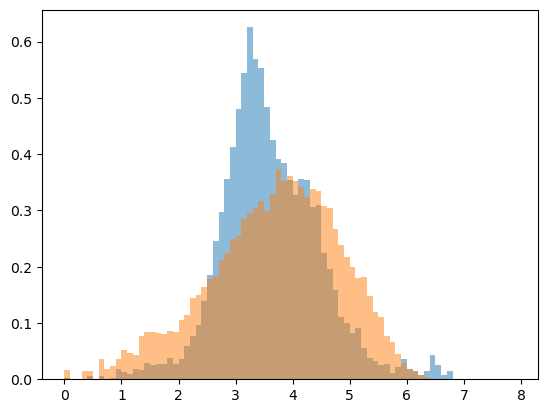

In [251]:
plt.hist(np.log10([co.end_pos-co.start_pos for co in my_crossovers]), alpha=0.5, bins=np.arange(0, 8, 0.1), density=True)
plt.hist(np.log10([x.end_pos-x.start_pos for x in shapeit_crossovers]), alpha=0.5, bins=np.arange(0, 8, 0.1), density=True)
plt.show()

In [252]:
shapeit_crossover_to_index = dict([(x, i) for i, x in enumerate(shapeit_crossovers)])


In [253]:
print(my_crossovers[0])
print(shapeit_crossovers[0])

Crossover(family='11004', chrom='10', start_pos=24331336, end_pos=24343206, child=['SSC02758', 'SSC02729'], is_mat=True, is_pat=False)
Crossover(family='13750', chrom='10', start_pos=74561, end_pos=74746, child='SS0012979', is_mat=True, is_pat=False)


In [254]:
my_has_match = np.zeros((len(my_crossovers),), dtype=bool)
shapeit_has_match = np.zeros((len(shapeit_crossovers),), dtype=bool)
my_matches = [[] for _ in my_crossovers]
shapeit_matches = [[] for _ in shapeit_crossovers]
my_is_mat = np.array([x.is_mat for x in my_crossovers])
shapeit_is_mat = np.array([x.is_mat for x in shapeit_crossovers])

child_to_shapeit_crossovers = defaultdict(list)
for x in shapeit_crossovers:
    child_to_shapeit_crossovers[x.child].append(x)

e = 10**5
for i, co in enumerate(my_crossovers):
    if i%10000==0:
        print(i, end=' ')
    overlap = [x for x in child_to_shapeit_crossovers[co.child[0]] if (x.start_pos <= co.end_pos+e) and (co.start_pos-e <= x.end_pos) and (co.is_mat==x.is_mat)]
    overlap += [x for x in child_to_shapeit_crossovers[co.child[1]] if (x.start_pos <= co.end_pos+e) and (co.start_pos-e <= x.end_pos) and (co.is_mat==x.is_mat)]
    if len(overlap)>0:
        my_has_match[i] = True
        my_matches[i] = overlap
        for x in overlap:
            shapeit_has_match[shapeit_crossover_to_index[x]] = True
            shapeit_matches[shapeit_crossover_to_index[x]].append(co)
            

print(np.sum(my_has_match)/len(my_has_match))
print(np.sum(shapeit_has_match)/len(shapeit_has_match))

print('precision', np.sum(my_has_match)/len(my_has_match))
print('recall', np.sum(shapeit_has_match)/len(shapeit_has_match))
  
print('\nmaternal precision', np.sum(my_has_match & my_is_mat)/np.sum(my_is_mat))
print('maternal recall', np.sum(shapeit_has_match & shapeit_is_mat)/np.sum(shapeit_is_mat))

print('\npaternal precision', np.sum(my_has_match & ~my_is_mat)/np.sum(~my_is_mat))
print('paternal recall', np.sum(shapeit_has_match & ~shapeit_is_mat)/np.sum(~shapeit_is_mat))
    

0 10000 0.9040393684642198
0.08219487722315945
precision 0.9040393684642198
recall 0.08219487722315945

maternal precision 0.9186467526589727
maternal recall 0.10076752478691946

paternal precision 0.8817538408423959
paternal recall 0.06308583700588354


In [255]:
blocksize = 5*10**6
#blocks = [0, 5*10**6, 130*10**6, 135*10**6]
blocks = range(0, 140*10**6, blocksize)
print('blocks', len(blocks))
interval_precision, interval_recall = np.zeros((len(blocks)-1,)), np.zeros((len(blocks)-1,))
interval_precision_confint =  np.zeros((len(blocks)-1,2))
interval_precision_mat, interval_recall_mat = np.zeros((len(blocks)-1,)), np.zeros((len(blocks)-1,))
interval_precision_pat, interval_recall_pat = np.zeros((len(blocks)-1,)), np.zeros((len(blocks)-1,))
interval_precision_confint_mat =  np.zeros((len(blocks)-1,2))
interval_precision_confint_pat =  np.zeros((len(blocks)-1,2))

for i, j in enumerate(blocks[:-1]):
    my_indices = np.array([(j <= co.end_pos) and (co.start_pos <= blocks[i+1]) for co in my_crossovers])
    shapeit_indices = np.array([(j <= x.end_pos) and (x.start_pos <= blocks[i+1]) for x in shapeit_crossovers])
    
    interval_precision[i] = np.sum(my_has_match[my_indices])/np.sum(my_indices)
    interval_precision_confint[i, :] = proportion_confint( np.sum(my_has_match[my_indices]),
                                                          np.sum(my_indices), method='agresti_coull')
    interval_recall[i] = np.sum(shapeit_has_match[shapeit_indices])/np.sum(shapeit_indices)

    interval_precision_mat[i] = np.sum(my_has_match[my_indices & my_is_mat])/np.sum(my_indices & my_is_mat)
    interval_precision_confint_mat[i, :] = proportion_confint( np.sum(my_has_match[my_indices & my_is_mat]),
                                                          np.sum(my_indices & my_is_mat), method='agresti_coull')
    interval_recall_mat[i] = np.sum(shapeit_has_match[shapeit_indices & shapeit_is_mat])/np.sum(shapeit_indices & shapeit_is_mat)
    
    interval_precision_pat[i] = np.sum(my_has_match[my_indices & ~my_is_mat])/np.sum(my_indices & ~my_is_mat)
    interval_precision_confint_pat[i, :] = proportion_confint( np.sum(my_has_match[my_indices & ~my_is_mat]),
                                                          np.sum(my_indices & ~my_is_mat), method='agresti_coull')
    interval_recall_pat[i] = np.sum(shapeit_has_match[shapeit_indices & ~shapeit_is_mat])/np.sum(shapeit_indices & ~shapeit_is_mat)
    

blocks 28


[0.75238095 0.96252927 0.95528899 0.9703154  0.94166667 0.88396349
 0.91415313 0.83944954 0.83732057 0.8778135  0.93650794 0.91158537
 0.93103448 0.87318087 0.92099323 0.92926045 0.93681917 0.89952153
 0.88461538 0.89013453 0.82685512 0.91798107 0.95652174 0.94797688
 0.96144578 0.97224558 0.74896552]
[0.50578035 0.95842956 0.96858639 0.98130841 0.94945848 0.90701754
 0.93931398 0.87570621 0.90062112 0.90513834 0.95505618 0.94063927
 0.94535519 0.91245791 0.93485342 0.93948127 0.95765472 0.91698113
 0.91549296 0.9235474  0.88095238 0.95321637 0.9762533  0.96086106
 0.97790055 0.97701149 0.64315353]
[0.84573304 0.96674584 0.93313953 0.95412844 0.91566265 0.81725888
 0.73076923 0.68292683 0.625      0.75862069 0.85882353 0.85321101
 0.91176471 0.80978261 0.88970588 0.91636364 0.89473684 0.86928105
 0.81818182 0.79831933 0.67123288 0.87671233 0.9132948  0.91160221
 0.93031359 0.96851574 0.80165289]


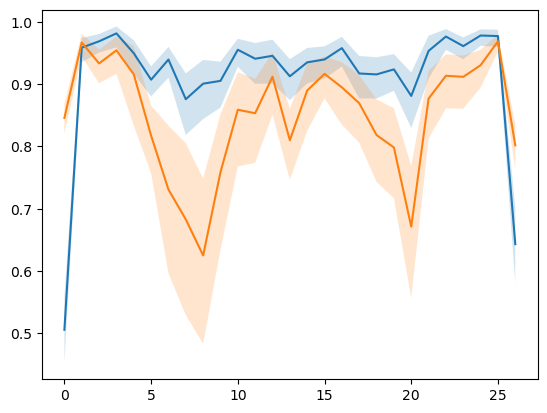

In [256]:
print(interval_precision)
print(interval_precision_mat)
print(interval_precision_pat)

#plt.plot(interval_precision)
#plt.fill_between(np.arange(len(blocks)-1), interval_precision_confint[:, 0], interval_precision_confint[:, 1], alpha=0.2)
plt.plot(interval_precision_mat)
plt.fill_between(np.arange(len(blocks)-1), interval_precision_confint_mat[:, 0], interval_precision_confint_mat[:, 1], alpha=0.2)
plt.plot(interval_precision_pat)
plt.fill_between(np.arange(len(blocks)-1), interval_precision_confint_pat[:, 0], interval_precision_confint_pat[:, 1], alpha=0.2)
plt.show()

In [261]:
print(np.median(list(child_to_crossovers.values())))


48.0


Chi2ContingencyResult(statistic=54.477653932552215, pvalue=1.5722553730085518e-13, dof=1, expected_freq=array([[7989.89993849, 5237.10006151],
       [ 848.10006151,  555.89993849]]))
Chi2ContingencyResult(statistic=611.2217413102551, pvalue=6.067618647385604e-135, dof=1, expected_freq=array([[11441.52224728,  1785.47775272],
       [ 1214.47775272,   189.52224728]]))


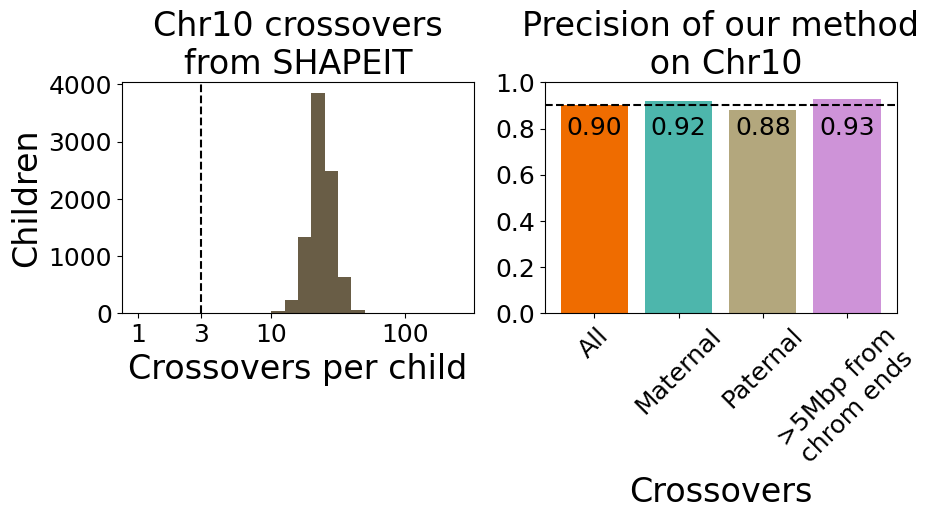

In [258]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.hist(np.log10(list(child_to_mat_crossovers.values())+list(child_to_pat_crossovers.values())), 
         bins=np.arange(0, 2.5, 0.1), color=colors[3])
plt.axvline(np.log10(np.median(platinum_mat_crossovers+platinum_pat_crossovers)), color='black', linestyle='--')
plt.xticks([0, np.log10(3), 1, 2], ['1', '3', '10', '100'], fontsize=18)
plt.yticks(fontsize=18)
plt.title('Chr10 crossovers\nfrom SHAPEIT', fontsize=24)
plt.xlabel('Crossovers per child', fontsize=24)
plt.ylabel('Children', fontsize=24)

plt.subplot(1, 2, 2)
my_indices = np.array([(5*10**6 <= co.end_pos) and (co.start_pos <= 130*10**6) for co in my_crossovers])
data = [np.sum(my_has_match)/len(my_has_match), 
         np.sum(my_has_match & my_is_mat)/np.sum(my_is_mat),
         np.sum(my_has_match & ~my_is_mat)/np.sum(~my_is_mat),
         np.sum(my_has_match & my_indices)/np.sum(my_indices),]
plt.bar([0, 1, 2, 3], data,
       color=colors[:3] + [colors[4]])
plt.title('Precision of our method\n on Chr10', fontsize=24)
for i in range(4):
    plt.text(i, data[0]-0.05, '%0.2f' % data[i], 
             fontsize=18, horizontalalignment='center', verticalalignment='top')
plt.ylim([0, 1])
plt.yticks(fontsize=18)
plt.xticks([0, 1, 2, 3], ['All', 'Maternal', 'Paternal', '>5Mbp from\nchrom ends', ], fontsize=18, rotation=45)
plt.xlabel('Crossovers', fontsize=24)
plt.axhline(np.sum(my_has_match)/len(my_has_match), color='black', linestyle='--')

plt.savefig('../plots/shapeit.png', bbox_inches="tight")
plt.savefig('../plots/Fig_6.png', bbox_inches="tight")
    
#if data_dir == '../../DATA/platinum':
#    plt.savefig('../plots/platinum.png', bbox_inches="tight")
#    plt.savefig('../plots/Fig_1.png', bbox_inches="tight")
#elif data_dir == '../../DATA/platinum_sim':
#    plt.savefig('../plots/platinum_sim.png', bbox_inches="tight")
#    plt.savefig('../plots/Fig_2.png', bbox_inches="tight")

print(stats.chi2_contingency([[np.sum(my_has_match & my_is_mat), np.sum(my_has_match & ~my_is_mat)],
                              [np.sum(~my_has_match & my_is_mat), np.sum(~my_has_match & ~my_is_mat)]]))

print(stats.chi2_contingency([[np.sum(my_has_match & my_indices), np.sum(my_has_match & ~my_indices)],
                              [np.sum(~my_has_match & my_indices), np.sum(~my_has_match & ~my_indices)]]))
